In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import os, sys
cwd = os.getcwd()

api_path_toy = os.path.join(cwd, '..', 'tools', 'toy_examples_utils')
#api_path_sir = os.path.join(cwd, '..', 'tools', 'sir_ais_sampling')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_toy)
#sys.path.append(api_path_sir)
sys.path.append(os.path.join(cwd, '..', 'tools', 'sampling_utils'))

In [67]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from toy_examples_utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_real_data, 
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           #xtry_langevin_sampling_plot_2d,
                           epoch_visualization,
                           plot_chain_metrics)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          #xtry_langevin_sampling,
                          gan_energy)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

from general_utils import DotDict

from metrics import Evolution

In [68]:
from pathlib import Path
figpath = Path('../figs')

# 2D Gaussians, true distribution

In [16]:
sigma

0.05

In [17]:
train_dataset_size

64000

In [69]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

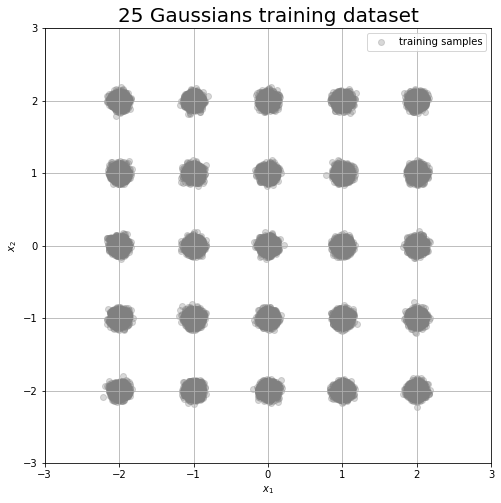

In [70]:
title = '25 Gaussians training dataset'
path_to_save = Path(figpath, '25_gaussians_training.pdf')
plot_real_data(X_train, title, path_to_save)

In [71]:
n_dim = 2
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = Gaussian_mixture(target_args).log_prob


n_dim = 2
loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [72]:
evols = dict()

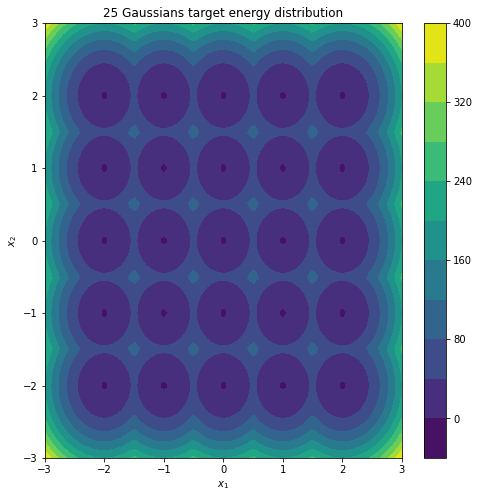

In [73]:
true_target_energy = Gaussian_mixture(target_args).energy

x_range = 3.0
y_range = 3.0
title = '25 Gaussians target energy distribution'
path_to_save = Path(figpath, '25_gaussians_energy.pdf')
plot_potential_energy(true_target_energy,
                      x_range,
                      y_range,
                      device,
                      path_to_save = path_to_save,
                      num_points = 100,
                      title = title)

In [8]:
batch_size_sample = 5000

In [74]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
n_steps = 50
n_batches = 10
batch_size_sample = 10000
langevin_sampling_plot_2d(true_target,
                          proposal,
                          X_train,  
                          batch_size_sample = batch_size_sample,
                          grad_step = grad_step,
                          eps_scale = eps_scale,
                          n_steps = n_steps,
                          n_batches = n_batches,
                          path_to_save=Path(figpath, '2d_known_target_ula.pdf'))

100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


In [14]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5
n_steps = 500
every = 50
z_last_np, zs = langevin_sampling(true_target,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)

zs = zs[0, ::every]
Xs_gen = zs

#X_gen = scaler.inverse_transform(X_gen.reshape(-1, X_gen.shape[-1])).reshape(X_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols['ULA'] = evol

100%|██████████| 1/1 [00:15<00:00, 15.04s/it]


In [182]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
#eps_scale = 1e-2
n_steps = 100
n_batches = 10
acceptance_rule = 'Hastings'
mala_sampling_plot_2d(true_target,
                      proposal,
                      X_train,  
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      path_to_save=Path(figpath, '2d_known_target_mala_hastings.pdf'))

100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


In [22]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5
n_steps = 500
every = 50

z_last_np, zs = mala_sampling(true_target,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               acceptance_rule = 'Hastings')

zs = zs[0, ::every]
Xs_gen = zs

#X_gen = scaler.inverse_transform(X_gen.reshape(-1, X_gen.shape[-1])).reshape(X_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'MALA, MH'] = evol

100%|██████████| 1/1 [00:29<00:00, 29.99s/it]


In [24]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)

batch_size_sample = 5000
n_steps = 500
every = 50
T = 5
betas = np.linspace(1., 0.0, T)

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = tempered_transitions_sampling(true_target,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               betas=betas)

zs = zs[0, ::every]
Xs_gen = zs

#X_gen = scaler.inverse_transform(X_gen.reshape(-1, X_gen.shape[-1])).reshape(X_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'Tempered transitions'] = evol

100%|██████████| 1/1 [01:38<00:00, 98.75s/it]


In [27]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

batch_size_sample = 5000
n_steps = 500
every = 50

T = 5
betas = np.linspace(1.0, 0.0, T)
N = 4

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = ais_vanilla_sampling(true_target,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               N=N,
                               betas=betas)


Xs_gen = zs[0, ::every]

#X_gen = scaler.inverse_transform(X_gen.reshape(-1, X_gen.shape[-1])).reshape(X_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'AIS, N={N}'] = evol

100%|██████████| 1/1 [01:36<00:00, 96.35s/it]


In [9]:
from ebm_sampling import iterated_ais_sampling

target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

batch_size_sample = 5000
n_steps = 500
every = 50

T = 5
betas = np.linspace(1.0, 0.0, T)
N = 4

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = iterated_ais_sampling(true_target,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               N=N,
                               betas=betas)


Xs_gen = zs[0, ::every]

#X_gen = scaler.inverse_transform(X_gen.reshape(-1, X_gen.shape[-1])).reshape(X_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'Iterated AIS, N={N}'] = evol

100%|██████████| 1/1 [02:08<00:00, 128.90s/it]


In [28]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

batch_size_sample = 5000
n_steps = 500
every = 50

T = 5
betas = np.linspace(1., 0., T)
rhos = np.linspace(0.8, 1., T)[::-1]
N = 4

grad_step = 1e-3
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = ais_sampling(true_target,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               N=N,
                               betas=betas,
                               rhos=rhos)


Xs_gen = zs[0, ::every, :, -1, :]

#X_gen = scaler.inverse_transform(X_gen.reshape(-1, X_gen.shape[-1])).reshape(X_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'CAIS, N={N}'] = evol

[01:27<04:40,  1.34it/s]
100%|██████████| 1/1 [05:50<00:00, 350.93s/it]


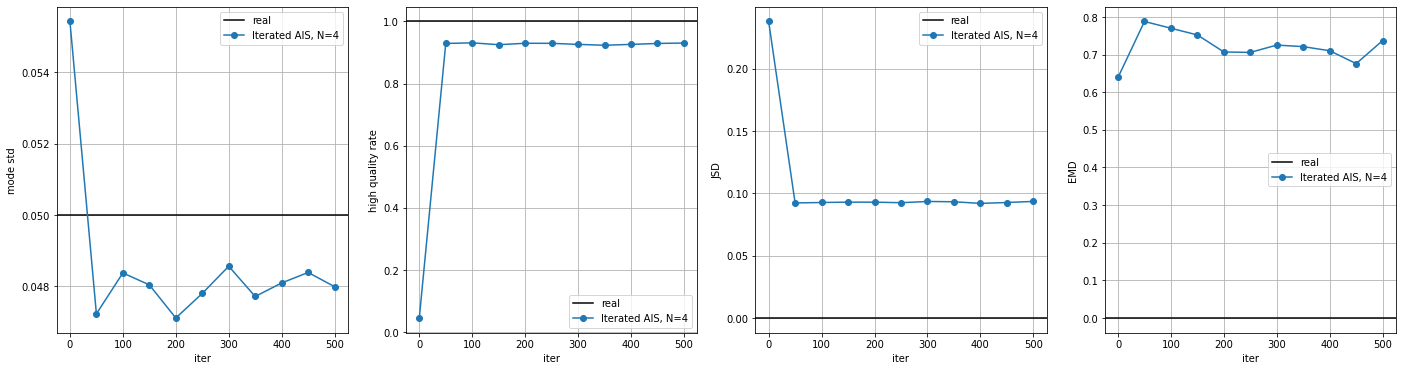

In [10]:
plot_chain_metrics(**evols)

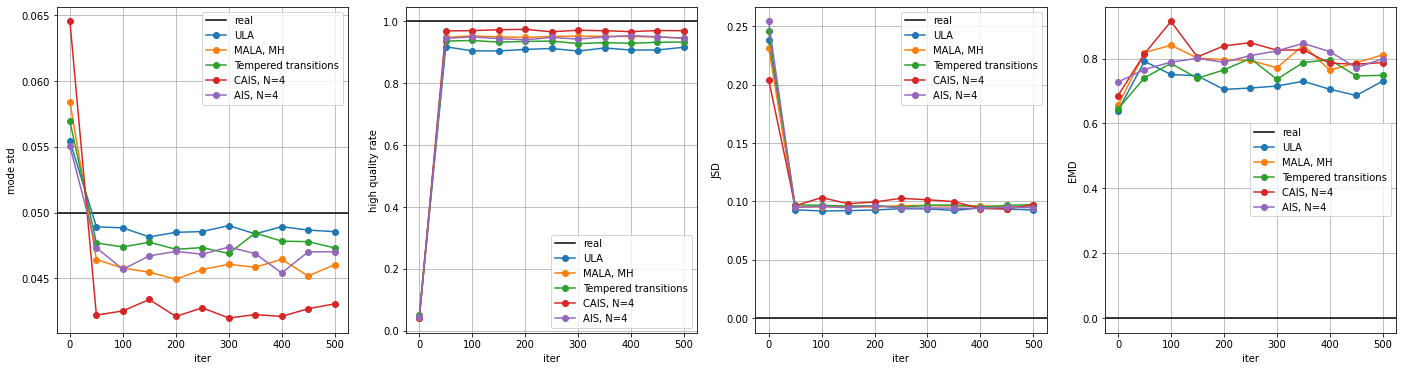

In [32]:
plot_chain_metrics(**evols, savepath=Path(figpath, '2d_known_target_chains_metrics.pdf'))

In [188]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
acceptance_rule = 'Barker'
mala_sampling_plot_2d(true_target,
                      proposal,
                      X_train,  
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      path_to_save=Path(figpath, '2d_known_target_mala_barker.pdf'))

100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


# 2D Gaussians, GANs

In [29]:
G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [30]:
discriminator_regexp = os.path.join(models_2d_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_2d_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [31]:
G.load_state_dict(torch.load(generator_name, map_location=device))
D.load_state_dict(torch.load(discriminator_name, map_location=device))

<All keys matched successfully>

In [32]:
G = G.to(device)
D = D.to(device)

In [33]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

In [43]:
batch_size_sample = 10000
x_range = 3.0
y_range = 3.0
path_to_final_save = Path(figpath, '25_gaussians_gan_samples.pdf')
path_to_save = figpath
sample_fake_data(G, X_train,  
                 x_range,
                 y_range,
                 scaler = scaler,
                 path_to_save = path_to_save,
                 path_to_final_save = path_to_final_save,
                 batch_size_sample = batch_size_sample)

In [12]:
x_range = 3.0
y_range = 3.0
plot_discriminator_2d(D,
                      x_range,
                      y_range,
                      scaler = scaler,
                      num_points = 700,
                      path_to_save=Path(figpath, '2d_gan_discriminator.pdf'))

In [13]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_plot_2d(G, 
                    D,
                    X_train, 
                    n_calib_pts = n_calib_pts,
                    scaler = scaler, 
                    batch_size_sample = batch_size_sample,
                    type_calibrator = type_calibrator,
                    normalize_to_0_1 = normalize_to_0_1,
                    path_to_save=Path(figpath, '2d_mhgan.pdf'))

Start to do MH sampling....


100%|██████████| 5000/5000 [01:02<00:00, 79.53it/s]


In [44]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normalize_to_0_1 = True 
log_prob = True

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

target_gan = partial(gan_energy, 
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [15]:
evols = dict()

In [54]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 100
n_batches = 10
langevin_sampling_plot_2d(target_gan,
                          proposal,
                          X_train,  
                          scaler = scaler, 
                          batch_size_sample = batch_size_sample,
                          grad_step = grad_step,
                          eps_scale = eps_scale,
                          n_steps = n_steps,
                          n_batches = n_batches,
                          latent_transform = G,
                          path_to_save=Path(figpath, '2d_gan_ula.pdf'))

100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


In [32]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)

n_steps = 500
every = 50
grad_step = 1e-3
eps_scale = 1e-2 #(grad_step * 2) ** 0.5 #1e-1
z_last_np, zs = langevin_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps)#,
                               #n_batches = n_batches)

zs = zs[0, ::every]

Xs_gen = G(torch.FloatTensor(zs, device=device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols['ULA'] = evol

100%|██████████| 1/1 [00:08<00:00,  8.09s/it]
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarning: invalid value encountered in multiply
  js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarning: invalid value encountered in multiply
  js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:221: RuntimeWarning: invalid value encountered in multiply
  kl = pi_g * (np.log(pi_g) - np.log(pi_d + 1e-10))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarni

In [26]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 500
n_batches = 10
acceptance_rule = 'Hastings'
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,  
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      latent_transform = G,
                      path_to_save=Path(figpath, '2d_gan_mala_hastings.pdf'))

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


In [27]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

n_steps = 500
every = 50

grad_step = 1e-3
eps_scale = 1e-2

z_last_np, zs = mala_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               acceptance_rule = 'Hastings')#,
                               #n_batches = n_batches)

zs = zs[0, ::every]
Xs_gen = zs

Xs_gen = G(torch.FloatTensor(zs, device=device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'MALA, MH'] = evol

100%|██████████| 1/1 [00:14<00:00, 14.62s/it]
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarning: invalid value encountered in multiply
  js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarning: invalid value encountered in multiply
  js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarning: invalid value encountered in multiply
  js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_ut

In [28]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 500
n_batches = 10
acceptance_rule = 'Barker'
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,  
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      latent_transform = G,
                      path_to_save=Path(figpath, '2d_gan_mala_barker.pdf'))

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


In [212]:
# target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

# evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
#target_log_prob=true_target, sigma=sigma, scaler=scaler)

# n_steps = 500
# every = 50
# N = 2
# z_last_np, zs = xtry_langevin_sampling(target_gan,
#                                proposal,  
#                                batch_size=batch_size_sample,
#                                n = batch_size_sample,
#                                N = N,
#                                grad_step = grad_step,
#                                eps_scale = eps_scale,
#                                n_steps = n_steps)#,
#                                #n_batches = n_batches)

# zs = zs[0, ::every]
# Xs_gen = zs

# Xs_gen = G(torch.FloatTensor(zs, device=device)).detach().cpu().numpy()
# Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

# for X_gen in Xs_gen:
#     evolution.invoke(torch.FloatTensor(X_gen))
# evol = evolution.as_dict()
# evols[f'X-Try, N={N}'] = evol

100%|██████████| 1/1 [00:41<00:00, 41.87s/it]


In [36]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0),
                      target_log_prob=true_target, sigma=sigma, scaler=scaler)

grad_step = 1e-3
eps_scale = 1e-2 #(grad_step * 2) ** 0.5

n_steps = 500
every = 50

betas = np.linspace(1., 0., 5)

z_last_np, zs = tempered_transitions_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               betas=betas)

zs = zs[0, ::every]
Xs_gen = zs

Xs_gen = G(torch.FloatTensor(zs, device=device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'Tempered transitions'] = evol

  0%|          | 0/1 [00:35<?, ?it/s]


KeyboardInterrupt: 

In [30]:
plot_fake_data_mode(Xs_gen[-1], X_train, mode='tempered tranitions', 
                    path_to_save=Path(figpath, '2d_gan_tempered_trans.pdf'))

In [34]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), 
                      target_log_prob=true_target, 
                      sigma=sigma, scaler=scaler)

grad_step = 1e-3
eps_scale = 1e-2 #(grad_step * 2) ** 0.5
n_steps = 500
every = 50
betas = np.linspace(1., 0., 5)
N = 20

z_last_np, zs = ais_vanilla_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               N=N,
                               betas=betas)

zs = zs[0, ::every]
Xs_gen = zs

Xs_gen = G(torch.FloatTensor(zs, device=device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'AIS, N={N}'] = evol

100%|██████████| 1/1 [10:23<00:00, 623.79s/it]
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarning: invalid value encountered in multiply
  js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarning: invalid value encountered in multiply
  js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_utils/metrics.py:227: RuntimeWarning: invalid value encountered in multiply
  js = .5 * (pi_g * (np.log(pi_g) - np.log(m)) + pi_d * (np.log(pi_d) - np.log(m)))
/media/Data/Archive/Common/Sirius2020/Sampling_control_optimization/diploma/gans_sampling/notebooks/../tools/sampling_u

In [37]:
plot_fake_data_mode(Xs_gen[-1], X_train, mode=f'AIS, N={N}', path_to_save=Path(figpath, '2d_gan_ais.pdf'))

In [38]:
target_sample = X_train[np.random.choice(np.arange(X_train.shape[0]), 1000)]

evolution = Evolution(target_sample, locs=torch.stack(locs, 0), target_log_prob=true_target, sigma=sigma, scaler=scaler)

batch_size_sample = 5000
n_steps = 500
every = 50

T = 5
betas = np.linspace(1., 0., T)
rhos = np.linspace(0.8, 1., T)[::-1]
N = 4

grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5

z_last_np, zs = ais_sampling(target_gan,
                               proposal,  
                               batch_size=batch_size_sample,
                               n = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               N=N,
                               betas=betas,
                               rhos=rhos)


Xs_gen = zs[0, ::every, :, -1, :]

Xs_gen = G(torch.FloatTensor(Xs_gen, device=device)).detach().cpu().numpy()
Xs_gen = scaler.inverse_transform(Xs_gen.reshape(-1, Xs_gen.shape[-1])).reshape(Xs_gen.shape)

for X_gen in Xs_gen:
    evolution.invoke(torch.FloatTensor(X_gen))
evol = evolution.as_dict()
evols[f'coolAIS, N={N}'] = evol

[01:04<04:02,  1.55it/s]
100%|██████████| 1/1 [04:25<00:00, 265.51s/it]


In [39]:
plot_fake_data_mode(Xs_gen[-1], X_train, mode=f'CAIS, N={N}', path_to_save=Path(figpath, '2d_gan_cais.pdf'))

In [81]:
# plot_fake_data_mode(Xs_gen[-1], X_train, mode='')

In [79]:
# plot_chain_metrics(**evols)

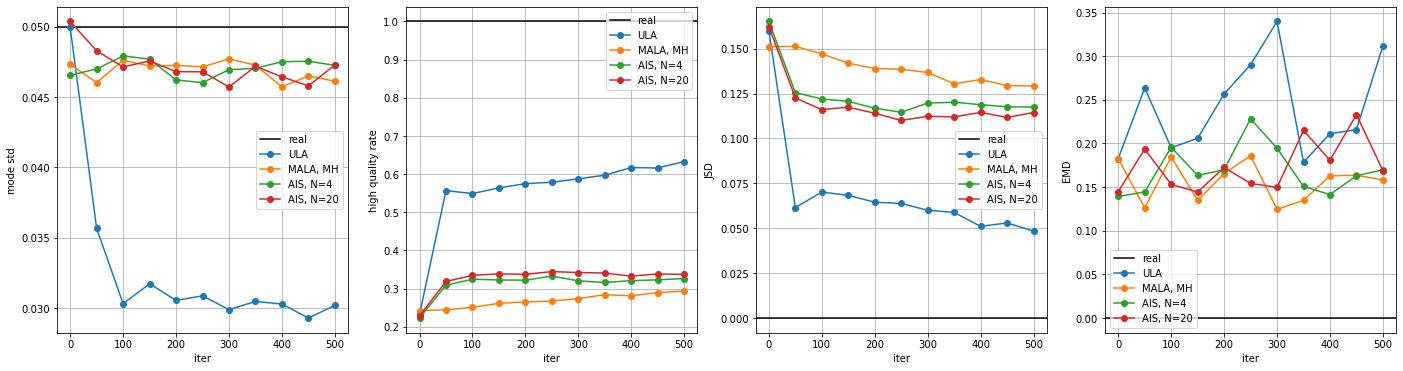

In [35]:
plot_chain_metrics(**evols, savepath=Path(figpath, '2d_gan_chain_metrics.pdf'))

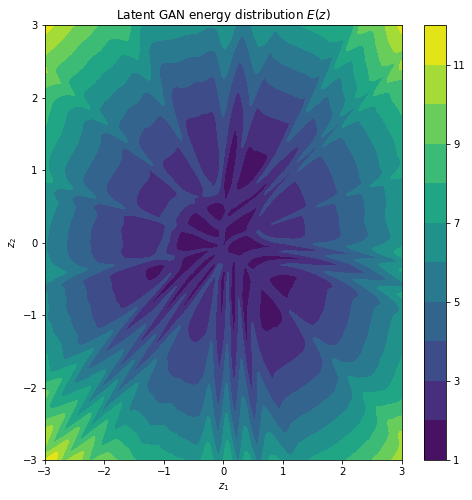

In [79]:
log_prob = False
target_gan_energy = partial(gan_energy, 
                            generator = G, 
                            discriminator = D, 
                            proposal = proposal,
                            normalize_to_0_1 = normalize_to_0_1,
                            log_prob = log_prob)
x_range = 3.0
y_range = 3.0
norm_grads = False
title = r'Latent GAN energy distribution $E(z)$'
path_to_save = Path(figpath, 'latent_gan_energy.pdf')
mode_visual = 'latent'
plot_potential_energy(target_gan_energy,
                      x_range,
                      y_range,
                      device,
                      path_to_save = path_to_save,
                      norm_grads = norm_grads,
                      num_points = 700,
                      title = title,
                      mode_visual = mode_visual)

In [60]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 100
n_batches = 10
batchsize = batch_size_sample // n_batches
X_langevin, zs = langevin_sampling(target_gan, proposal, batchsize, batch_size_sample, 
                                       None, None, None, None, 
                                       n_steps, grad_step, eps_scale)

100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


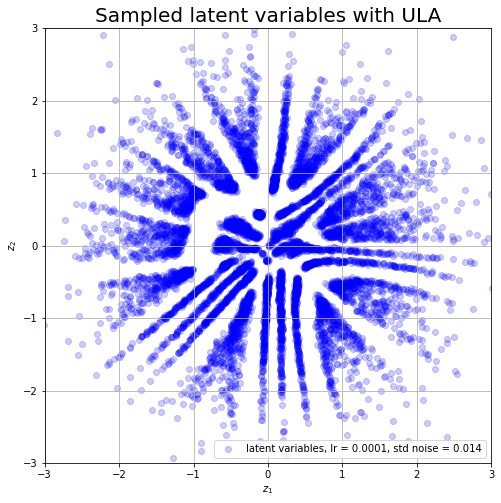

In [78]:
path_to_save = Path(figpath, 'latent_variables_ula.pdf')
figsize=(8,8)
plt.figure(figsize=figsize)
plt.xlim(-3., 3.)
plt.ylim(-3., 3.)
title = f"Sampled latent variables with ULA"
plt.title(title, fontsize=20)
plt.scatter(X_langevin[:,:1], X_langevin[:,1:], alpha=0.2, color='blue', 
            marker='o', label = f'latent variables, lr = {grad_step}, std noise = {round(eps_scale, 3)}')
plt.grid(True)
plt.xlabel(r"$z_{1}$")
plt.ylabel(r"$z_{2}$")
plt.legend()
plt.savefig(path_to_save)
plt.show()

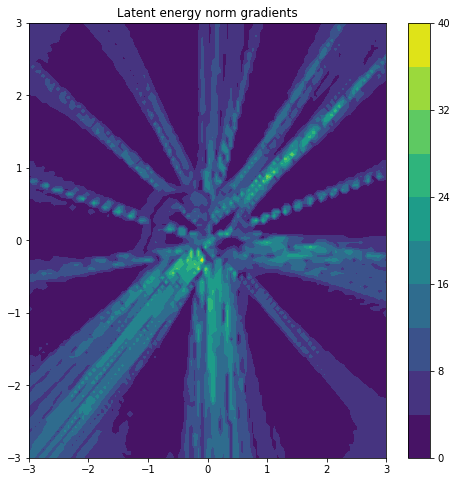

In [63]:
x_range = 3.0
y_range = 3.0
norm_grads = True
plot_potential_energy(target_gan_energy,
                      x_range,
                      y_range,
                      device,
                      norm_grads = norm_grads,
                      num_points = 100)